# 卷积神经网络 (CNN)

> Adapted from [PyTorch's official tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) by [@RainEggplant](mailto:i@raineggplant.com)

在本次教程中，我们将学习如何使用 PyTorch，从零搭建一个卷积神经网络，完成 [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) 数据集上的分类任务。

## 0. 环境配置

本次教程要用到的大部分包和 Tutorial 4 相同，所以你可以继续使用之前的 python 环境。唯一新增的包是 [torchinfo](https://github.com/TylerYep/torchinfo)，它可以显示模型的摘要信息。

如果你使用的是 conda 环境，请执行如下命令安装：

In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} -c conda-forge torchinfo=1.5.4

Solving environment: ...working... done

# All requested packages already installed.



否则执行以下命令安装：

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install torchinfo==1.5.4

安装完成后，让我们试着执行下面的代码，导入本次教程需要的包（如果有报错，请检查你的 python 环境是否配置正确）。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from pathlib import Path
from torchinfo import summary

## 1. 卷积神经网络编程基础

回忆我们课上讲到的卷积神经网络中的常用网络层，有卷积层、池化层。下面让我们看看如何在 PyTorch 中定义它们。

### 1.1 二维卷积层

要定义一个二维卷积层，我们使用 `nn.Conv2d` 对象。其参数为 (`in_channels`, `out_channels`, `kernel_size`)，其他参数 (`stride`, `padding`, `dilation` 等) 常以关键字形式给出。（[PyTorch 官方文档](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)）

例如：定义一个输入通道数为 16，输出通道数为 33，卷积核大小为 3x5 (高 3 宽 5），步长为 2x1，填充为 4x2，空洞为 3x1 的卷积层。

```python
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
```

让我们动手尝试一下：

In [3]:
# 定义一个输入通道数为 3，输出通道数为 6，卷积核大小为 5x5 的卷积层
conv_layer = nn.Conv2d(3, 6, 5)
# 显示卷积层的摘要和当输入批大小为 4，通道数为 3，长、宽都为 32 的图像时的输出大小
summary(conv_layer, input_size=(4, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Conv2d                                   [4, 6, 28, 28]            456
Total params: 456
Trainable params: 456
Non-trainable params: 0
Total mult-adds (M): 1.43
Input size (MB): 0.05
Forward/backward pass size (MB): 0.15
Params size (MB): 0.00
Estimated Total Size (MB): 0.20

我们不妨自己验算一下：
- $卷积层参数 = (K_H \times K_W \times C_{in} + 1) \times C_{out} = (5 \times 5 \times 3 + 1) \times 6 = 456$
- $输出特征图宽度 = (W_{in} - K_W + 2P) / S + 1 = (32 - 5 + 2 \times 0) / 1 + 1 = 28$

和 `torchinfo.summary` 的输出一致，说明我们的定义是正确的。

### 1.2 二维池化层

要定义一个二维卷积层，我们使用 `nn.MaxPool2d` 对象。其参数为 (`kernel_size`， `stride`)，其他参数 (`padding`, `dilation` 等) 常以关键字形式给出。（[PyTorch 官方文档](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)）

让我们动手尝试一下：

In [4]:
# 定义一个尺寸为 2x2，步长为 2 的最大池化层
pool_layer = nn.MaxPool2d(2, 2)
# 显示池化层的摘要和当输入批大小为 4，通道数为 6，长、宽都为 28 的图像时的输出大小
summary(pool_layer, input_size=(4, 6, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MaxPool2d                                [4, 6, 14, 14]            --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.08
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.08

注意到了吗，池化层是没有训练参数的。简单计算一下，$输出特征图高度 = (28 - 2 + 2 \times 0) / 2 + 1 = 14$，与
 `torchinfo.summary` 的输出一致。

### 1.3 其他卷积神经网络中会用到的卷积层与池化层

参见 PyTorch 官方文档：[Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers) 与 [Pooling Layers](https://pytorch.org/docs/stable/nn.html#pooling-layers)。


## 2. 数据集准备

### 2.1 CIFAR 简介
本次教程使用的数据集是 [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)。它共有 10x6000 张 32x32 的 RGB 图片，对应 10 类物体。其中训练集、测试集分别占有 50000 张和 10000 张。以下为数据集的示例图：

![CIFAR10 Dataset](https://pytorch.org/tutorials/_images/cifar10.png)

### 2.2 为数据集指定变换 (transform)

在图像相关的任务中，大多数时候，我们并不直接使用原始的图像数据来训练网络，而是先对数据做一些变换，再将变换后的数据输入网络。一些变换是为了转换数据类型，统一图像的尺寸；一些变换是为了将数据取值标准化，改善网络学习的效果；另一些变换（如随机翻转、随机裁剪）是为了对数据进行增广 (augmentation)，增强网络的泛化能力。

`torchvision.transforms` 模块提供了丰富的变换，感兴趣的同学可以参考 [Transforming and augmenting images](https://pytorch.org/vision/stable/transforms.html).

在这里，我们仅把图像转化为 PyTorch 的基本类型 `Tensor`，然后对其进行标准化，使得像素值位于 $[-1, 1]$。之后，你也可以尝试加入一些数据增广的变换，看看训练好的网络的准确率是否有提升。

执行以下代码以定义变换：

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### 2.3 创建 CIFAR 数据集

执行以下代码以创建训练集与测试集。程序将自动下载数据集到 `data` 目录下并解压。

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


如果因网络原因下载失败，请通过 [此链接](https://cloud.tsinghua.edu.cn/f/6321272a6ca4402d9655/) 下载 `cifar-10-python.tar.gz` 并将其保存在 `data` 目录下，然后重新执行以上代码。

### 2.4 创建 DataLoader

有印象吗，我们在第 3 次教程中已经使用过 DataLoader 了，它可以多进程地从数据集中成批地读取数据。（ Tips: 调试时一般将 `num_workers` 设置为 `0`，DataLoader 便会使用主进程读取数据，可以避免多进程调试的一些问题）

执行以下代码创建训练集、测试集的 DataLoader:

In [7]:
batch_size = 4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

### 2.5 看一看！

让我们看看数据集中都有什么吧！


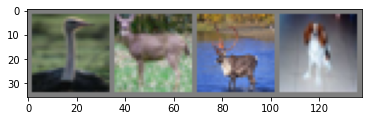

bird  deer  deer  dog  


In [8]:
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 3. 定义 CNN 模型

先阅读以下代码，你能想象出网络的结构吗（这其实就是 LeNet 的结构）？然后执行代码，定义网络并创建一个实例：

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

让我们用 `torchinfo.summary` 看看网络每一层的输入、输出尺寸与参数量。不妨先动手计算一下，再看看你的结果是否正确。

In [10]:
summary(net, input_size=(4, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [4, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [4, 6, 14, 14]            --
├─Conv2d: 1-3                            [4, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [4, 16, 5, 5]             --
├─Linear: 1-5                            [4, 120]                  48,120
├─Linear: 1-6                            [4, 84]                   10,164
├─Linear: 1-7                            [4, 10]                   850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (M): 2.63
Input size (MB): 0.05
Forward/backward pass size (MB): 0.21
Params size (MB): 0.25
Estimated Total Size (MB): 0.51

## 4. 定义损失函数和优化器

我们使用分类问题常用的交叉熵损失，采用带动量的随机梯度下降优化器。


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 5. 训练网络

让我们先测试以下你的电脑是否支持 CUDA，如果支持的话，我们就在 GPU 上训练网络，速度会有很大的提升。如果输出 'cuda' 则说明是支持的。

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


下面正式在训练集上训练。注意我们将模型移动到了设备 `device` 上，并且设置其为训练模式。训练时，数据也应当与模型处于相同的设备上。

In [13]:
n_epoch = 5  # loop over the dataset for `n_epoch` times
net = net.to(device)  # move net to `device` (GPU or CPU)
net.train()  # set net to train mode

for epoch in range(n_epoch):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # move the inputs to `device`
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.212
[1,  4000] loss: 1.891
[1,  6000] loss: 1.687
[1,  8000] loss: 1.591
[1, 10000] loss: 1.526
[1, 12000] loss: 1.451
[2,  2000] loss: 1.396
[2,  4000] loss: 1.376
[2,  6000] loss: 1.332
[2,  8000] loss: 1.339
[2, 10000] loss: 1.295
[2, 12000] loss: 1.256
[3,  2000] loss: 1.212
[3,  4000] loss: 1.206
[3,  6000] loss: 1.190
[3,  8000] loss: 1.190
[3, 10000] loss: 1.165
[3, 12000] loss: 1.173
[4,  2000] loss: 1.106
[4,  4000] loss: 1.085
[4,  6000] loss: 1.104
[4,  8000] loss: 1.074
[4, 10000] loss: 1.075
[4, 12000] loss: 1.100
[5,  2000] loss: 1.002
[5,  4000] loss: 1.014
[5,  6000] loss: 1.038
[5,  8000] loss: 1.021
[5, 10000] loss: 1.032
[5, 12000] loss: 1.038
Finished Training


试一试保存模型吧！

In [14]:
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
checkpoint_path = checkpoint_dir / f'cifar_net-epoch_{n_epoch}.pth'
torch.save(net.state_dict(), checkpoint_path)

更多模型与数据的保存相关，请参见 [Serialization semantics](https://pytorch.org/docs/stable/notes/serialization.html)。


## 6. 测试网络

### 6.1 （可选）加载保存的模型

如果你有已经保存的模型，可以执行下面的代码加载。如果你在上面的步骤中已经训练好一个模型，也可以跳过这一步。

In [15]:
net = Net()
net.load_state_dict(torch.load(checkpoint_path, map_location=device))
net = net.to(device)

### 6.2 随便测试一组数据

注意网络的输出 `output` 是 Bx10 的张量，代表每一张图片对应 10 个类别的能量。能量越大，就越可能是对应的类别。因此，我们取最大值对应的索引作为预测类别。

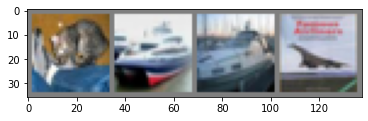

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  ship 


In [16]:
net.eval()  # set net to eval mode

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# use our model to predict
images = images.to(device)  # remember to move data to `device`
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

### 6.3 统计测试集上的分类正确率

测试时，一般需要将网络设置为 eval 模式（尽管对上面这个网络来说没有必要）。因为测试时无需用到梯度信息，我们使用 `torch.no_grad` 临时禁用梯度，以节省资源并加快速度。

In [17]:
net.eval()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print overall accuracy
n_correct = sum([correct_pred[classname] for classname in classes])
n_total = sum([total_pred[classname] for classname in classes])
accuracy = 100 * n_correct / n_total
print(f'Overall accuracy of the network on the {n_total} test images: {accuracy:.1f} %')

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * correct_count / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Overall accuracy of the network on the 10000 test images: 61.5 %
Accuracy for class: plane is 52.2 %
Accuracy for class: car   is 75.1 %
Accuracy for class: bird  is 55.8 %
Accuracy for class: cat   is 46.1 %
Accuracy for class: deer  is 57.2 %
Accuracy for class: dog   is 42.3 %
Accuracy for class: frog  is 60.5 %
Accuracy for class: horse is 69.0 %
Accuracy for class: ship  is 83.8 %
Accuracy for class: truck is 73.1 %


## 7. 改进

### 7.1 进行数据增强

我们可以对数据进行增强以提高模型的泛化能力。尝试修改 1.2 节的变换，例如增加随机水平翻转：

```python
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(0.5)])
```

### 7.2 改进网络结构

下面提供几个简单的改进思路：
- 增加特征图的通道数。我们知道特征图的每一个通道对应网络学习到的一类特征，增加特征的数量可能会帮助网络更好地分类。
- 近期的研究大多使用步长为 2 的卷积代替池化层进行下采样，一般来说效果会更好。想要深入了解可以阅读 [Striving for Simplicity: The All Convolutional Net](https://arxiv.org/abs/1412.6806)。
- 引入 Batch Normalization 层。

不妨自己动手实现一下，看看模型的分类正确率是否得到了提升。